In [1]:
#Image based prediction

import pandas as pd

# Load the cleaned movie dataset
df = pd.read_csv("C:\\Users\\yalav\\OneDrive\\Documents\\python\\project\\strictly_balanced_top10_cleaned.csv")

print("✅ Dataset loaded successfully!")
print(f"📦 Total movies in dataset: {len(df)}")

# Check available columns
print("\n🧱 Columns:")
print(df.columns.tolist())



✅ Dataset loaded successfully!
📦 Total movies in dataset: 111896

🧱 Columns:
['id', 'genres', 'overview', 'poster_path', 'keywords', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western', 'poster_url', 'clean_overview']


In [2]:
# Keep only rows where poster_url is not missing
df_with_posters = df.dropna(subset=['poster_url'])

print(f"🎬 Movies with valid poster URLs: {len(df_with_posters)}")


🎬 Movies with valid poster URLs: 111896


In [24]:
# Shuffle the dataframe first
mini_df = df_with_posters.sample(n=33000, random_state=42).reset_index(drop=True)

print(f"✅ Randomly sampled {len(mini_df)} movies for mini poster dataset.")


✅ Randomly sampled 33000 movies for mini poster dataset.


In [25]:
'''import os
import requests
from tqdm import tqdm

save_folder = "mini_posters"
os.makedirs(save_folder, exist_ok=True)

poster_urls = mini_df['poster_url'].tolist()

for url in tqdm(poster_urls, desc="Downloading mini posters"):
    try:
        filename = url.split("/")[-1]''
        save_path = os.path.join(save_folder, filename)

        if os.path.exists(save_path):
            continue

        response = requests.get(url, timeout=5)
        if response.status_code == 200:
            with open(save_path, 'wb') as f:
                f.write(response.content)
        else:
            print(f"❌ Failed to download: {url}")

    except Exception as e:
        print(f"❌ Error downloading {url}: {e}")'''


'import os\nimport requests\nfrom tqdm import tqdm\n\nsave_folder = "mini_posters"\nos.makedirs(save_folder, exist_ok=True)\n\nposter_urls = mini_df[\'poster_url\'].tolist()\n\nfor url in tqdm(poster_urls, desc="Downloading mini posters"):\n    try:\n        filename = url.split("/")[-1]\'\'\n        save_path = os.path.join(save_folder, filename)\n\n        if os.path.exists(save_path):\n            continue\n\n        response = requests.get(url, timeout=5)\n        if response.status_code == 200:\n            with open(save_path, \'wb\') as f:\n                f.write(response.content)\n        else:\n            print(f"❌ Failed to download: {url}")\n\n    except Exception as e:\n        print(f"❌ Error downloading {url}: {e}")'

C:\Users\yalav\AppData\Local\Temp\ipykernel_22728\270621776.py:19: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\yalav\movie_env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


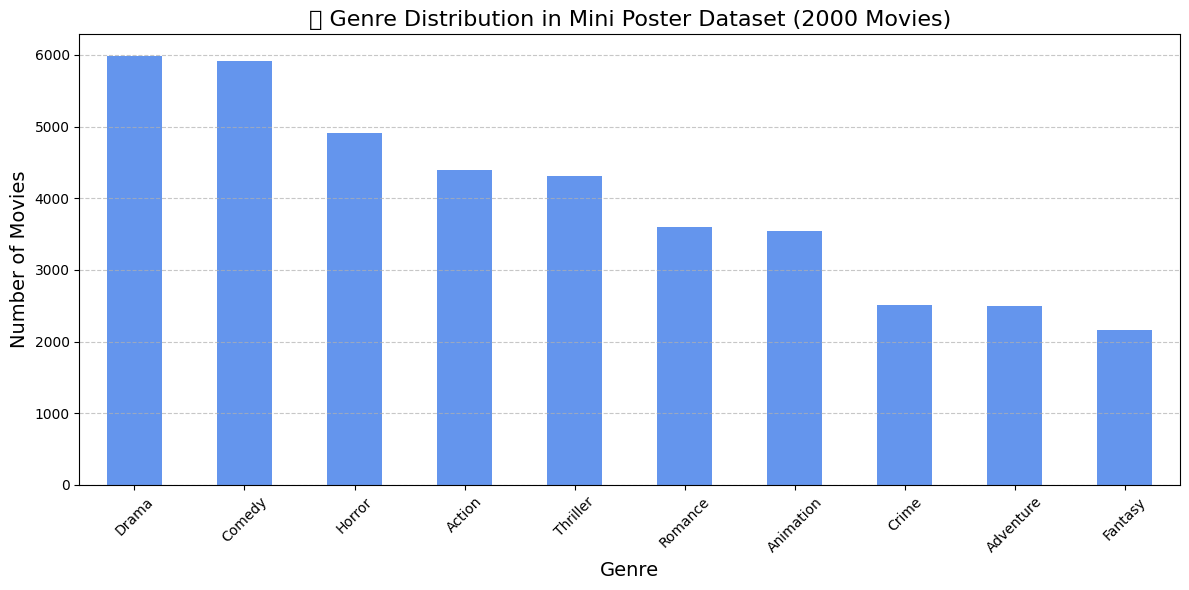

In [45]:
# Plot data
import matplotlib.pyplot as plt

# Define the genre columns you care about
genre_columns = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
                 'Drama', 'Fantasy', 'Horror', 'Romance', 'Thriller']

# Count how many movies belong to each genre
genre_counts = mini_df[genre_columns].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='cornflowerblue')
plt.title("🎬 Genre Distribution in Mini Poster Dataset (2000 Movies)", fontsize=16)
plt.xlabel("Genre", fontsize=14)
plt.ylabel("Number of Movies", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [46]:
# Poster Dataset
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os
import torch

from torch.utils.data import Dataset
from PIL import Image, UnidentifiedImageError
import os
import torch

class PosterGenreDataset(Dataset):
    def __init__(self, dataframe, image_folder, genre_columns, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.image_folder = image_folder
        self.genre_columns = genre_columns
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        poster_filename = row['poster_url'].split('/')[-1]
        img_path = os.path.join(self.image_folder, poster_filename)

        try:
            image = Image.open(img_path).convert('RGB')
        except (FileNotFoundError, UnidentifiedImageError):
            return None  # Skip unreadable image

        if self.transform:
            image = self.transform(image)

        labels = row[self.genre_columns].values.astype('float32')
        return image, torch.tensor(labels)

        
from torch.utils.data.dataloader import default_collate

def safe_collate(batch):
    batch = [sample for sample in batch if sample is not None]
    if len(batch) == 0:
        return None
    return default_collate(batch)


In [47]:
# Image Transforms for Posters
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])


In [48]:
# Create dataset and DataLoader
from torch.utils.data import random_split, DataLoader

# Define genres again
genre_columns = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
                 'Drama', 'Fantasy', 'Horror', 'Romance', 'Thriller']

# Create dataset
from torch.utils.data import DataLoader

poster_dataset = PosterGenreDataset(dataframe=mini_df,
                                    image_folder="mini_posters",
                                    genre_columns=genre_columns,
                                    transform=transform)

train_size = int(0.8 * len(poster_dataset))
val_size = len(poster_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(poster_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=safe_collate)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=safe_collate)


In [49]:
# Pre-trained RESNET-18 Model
import torch
import torch.nn as nn
import torchvision.models as models

# 1. Load ResNet-18 pretrained on ImageNet
resnet = models.resnet18(pretrained=True)
print(resnet)

# 2. Modify the final FC layer
num_features = resnet.fc.in_features  # Number of input features to final layer
print(num_features)
resnet.fc = nn.Linear(num_features, len(genre_columns))  # 18 genres
print(resnet.fc)

# 3. Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
resnet = resnet.to(device)

print("✅ ResNet-18 loaded and modified for genre prediction!")

C:\Users\yalav\movie_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\yalav\movie_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [50]:
# Train Set-UP
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

print("✅ Loss function and optimizer ready!")

✅ Loss function and optimizer ready!


In [51]:
from tqdm import tqdm
from sklearn.metrics import f1_score

train_losses, val_losses = [], []
train_micro_f1s, val_micro_f1s = [], []

def train_resnet(resnet, train_loader, val_loader, epochs=5):
    for epoch in range(epochs):
        resnet.train()
        running_loss = 0
        y_true_train = []
        y_pred_train = []

        print(f"\n🚀 Epoch {epoch + 1}/{epochs}")
        for batch in tqdm(train_loader, desc="Training", leave=False):
            if batch is None:
                continue  # skip batch with only invalid samples
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend((preds >= 0.5).astype(int))

        avg_train_loss = running_loss / len(train_loader)
        train_micro = f1_score(y_true_train, y_pred_train, average='micro')
        train_losses.append(avg_train_loss)
        train_micro_f1s.append(train_micro)

        val_loss, val_micro = validate_resnet(resnet, val_loader)
        val_losses.append(val_loss)
        val_micro_f1s.append(val_micro)

        print(f"📚 Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Train Micro-F1: {train_micro:.4f} | Val Loss: {val_loss:.4f} | Val Micro-F1: {val_micro:.4f}")

def validate_resnet(model, val_loader):
    model.eval()
    running_loss = 0
    y_true_val = []
    y_pred_val = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            if batch is None:
                continue
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            preds = torch.sigmoid(outputs).cpu().numpy()
            y_true_val.extend(labels.cpu().numpy())
            y_pred_val.extend((preds >= 0.5).astype(int))

    avg_val_loss = running_loss / len(val_loader)
    val_micro = f1_score(y_true_val, y_pred_val, average='micro')
    return avg_val_loss, val_micro


In [52]:
# Plot Results
def plot_training_curves(train_losses, val_losses, train_micro_f1s, val_micro_f1s):
    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.plot(val_losses, label="Validation Loss", marker='o')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Micro F1
    plt.subplot(1, 2, 2)
    plt.plot(train_micro_f1s, label="Train Micro-F1", marker='o')
    plt.plot(val_micro_f1s, label="Validation Micro-F1", marker='o')
    plt.title("Micro F1 Score per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [43]:
from PIL import Image, UnidentifiedImageError

def is_valid_image(filepath):
    try:
        Image.open(filepath).verify()
        return True
    except (FileNotFoundError, UnidentifiedImageError, OSError):
        return False

df['filename'] = df['poster_url'].apply(lambda url: url.split('/')[-1])
df['filepath'] = df['filename'].apply(lambda f: os.path.join("mini_posters", f))
df = df[df['filepath'].apply(is_valid_image)]


In [53]:
# Train
train_resnet(resnet, train_loader, val_loader, epochs=5)


🚀 Epoch 1/5


📚 Epoch 1/5 | Train Loss: 0.3350 | Train Micro-F1: 0.1367 | Val Loss: 0.3233 | Val Micro-F1: 0.1678

🚀 Epoch 2/5


📚 Epoch 2/5 | Train Loss: 0.3147 | Train Micro-F1: 0.2054 | Val Loss: 0.3231 | Val Micro-F1: 0.2502

🚀 Epoch 3/5


📚 Epoch 3/5 | Train Loss: 0.3031 | Train Micro-F1: 0.2602 | Val Loss: 0.3279 | Val Micro-F1: 0.2375

🚀 Epoch 4/5


📚 Epoch 4/5 | Train Loss: 0.2926 | Train Micro-F1: 0.3089 | Val Loss: 0.3078 | Val Micro-F1: 0.3151

🚀 Epoch 5/5


📚 Epoch 5/5 | Train Loss: 0.2793 | Train Micro-F1: 0.3651 | Val Loss: 0.3063 | Val Micro-F1: 0.2790


In [54]:
# Save model state_dict after training
torch.save(resnet.state_dict(), "poster_genre_classifier.pth")
print("✅ Trained poster model saved as 'poster_genre_classifier.pth'")


✅ Trained poster model saved as 'poster_genre_classifier.pth'


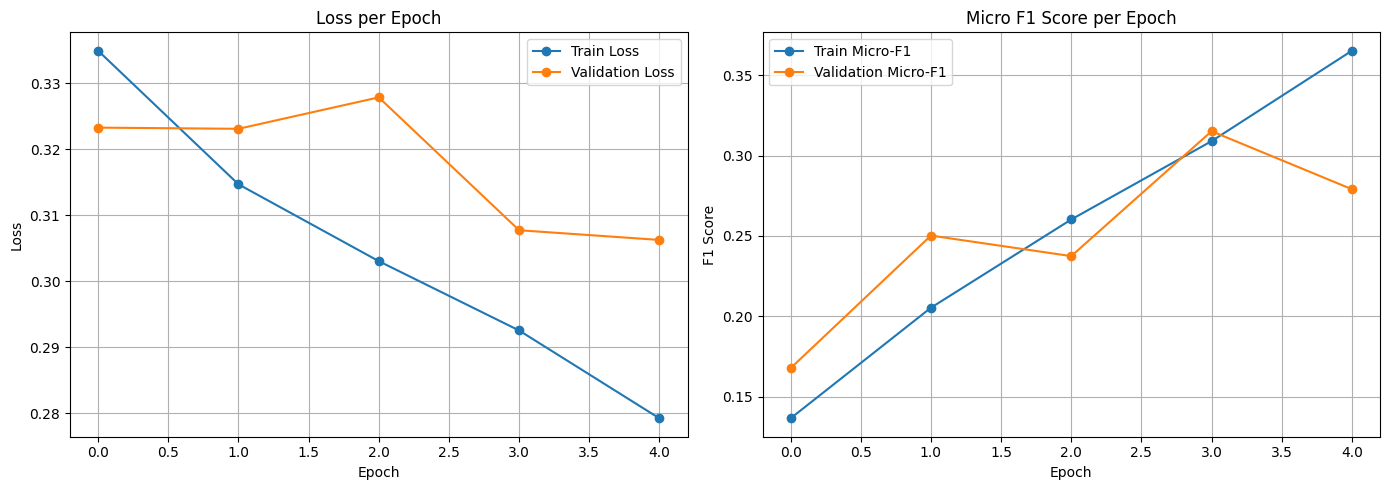

In [55]:
# Plot
plot_training_curves(train_losses, val_losses, train_micro_f1s, val_micro_f1s)


In [56]:
# Predict on trained
def predict_poster_genre(image_path, model, transform, genre_columns, threshold=0.5):
    from PIL import Image
    import torch

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension

    model.eval()
    with torch.no_grad():
        output = model(image)
        probs = torch.sigmoid(output).squeeze().numpy()

    # Apply threshold to get genres
    predicted_genres = [genre for genre, prob in zip(genre_columns, probs) if prob >= threshold]

    return predicted_genres


In [60]:
### Predict Function
# Assume you have a new poster image (local file)
import random
import matplotlib.pyplot as plt
from PIL import Image

def predict_and_show_posters(model, dataframe, image_folder, transform, genre_columns, num_images=10, threshold=0.5):
    import matplotlib.pyplot as plt
    from PIL import Image
    import os
    import torch

    model.eval()
    selected_rows = dataframe.sample(n=num_images, random_state=42)

    plt.figure(figsize=(20, 10))

    for idx, row in enumerate(selected_rows.itertuples()):
        poster_filename = getattr(row, 'poster_url').split('/')[-1]
        img_path = os.path.join(image_folder, poster_filename)

        try:
            image = Image.open(img_path).convert('RGB')
            input_img = transform(image).unsqueeze(0).to(device)  # ✅ Move input to same device as model

            with torch.no_grad():
                output = model(input_img)
                probs = torch.sigmoid(output).squeeze().cpu().numpy()

            predicted_genres = [genre for genre, prob in zip(genre_columns, probs) if prob >= threshold]

            plt.subplot(2, 5, idx+1)
            plt.imshow(image)
            plt.axis('off')
            title = "\n".join(predicted_genres) if predicted_genres else "No Genre"
            plt.title(title, fontsize=10)

        except Exception as e:
            print(f"❌ Error with {poster_filename}: {e}")
            continue

    plt.tight_layout()
    plt.show()




❌ Error with uUhzpZ1oa7b4qOqzgFSjcZ1ceio.jpg: [Errno 2] No such file or directory: 'mini_posters\\uUhzpZ1oa7b4qOqzgFSjcZ1ceio.jpg'


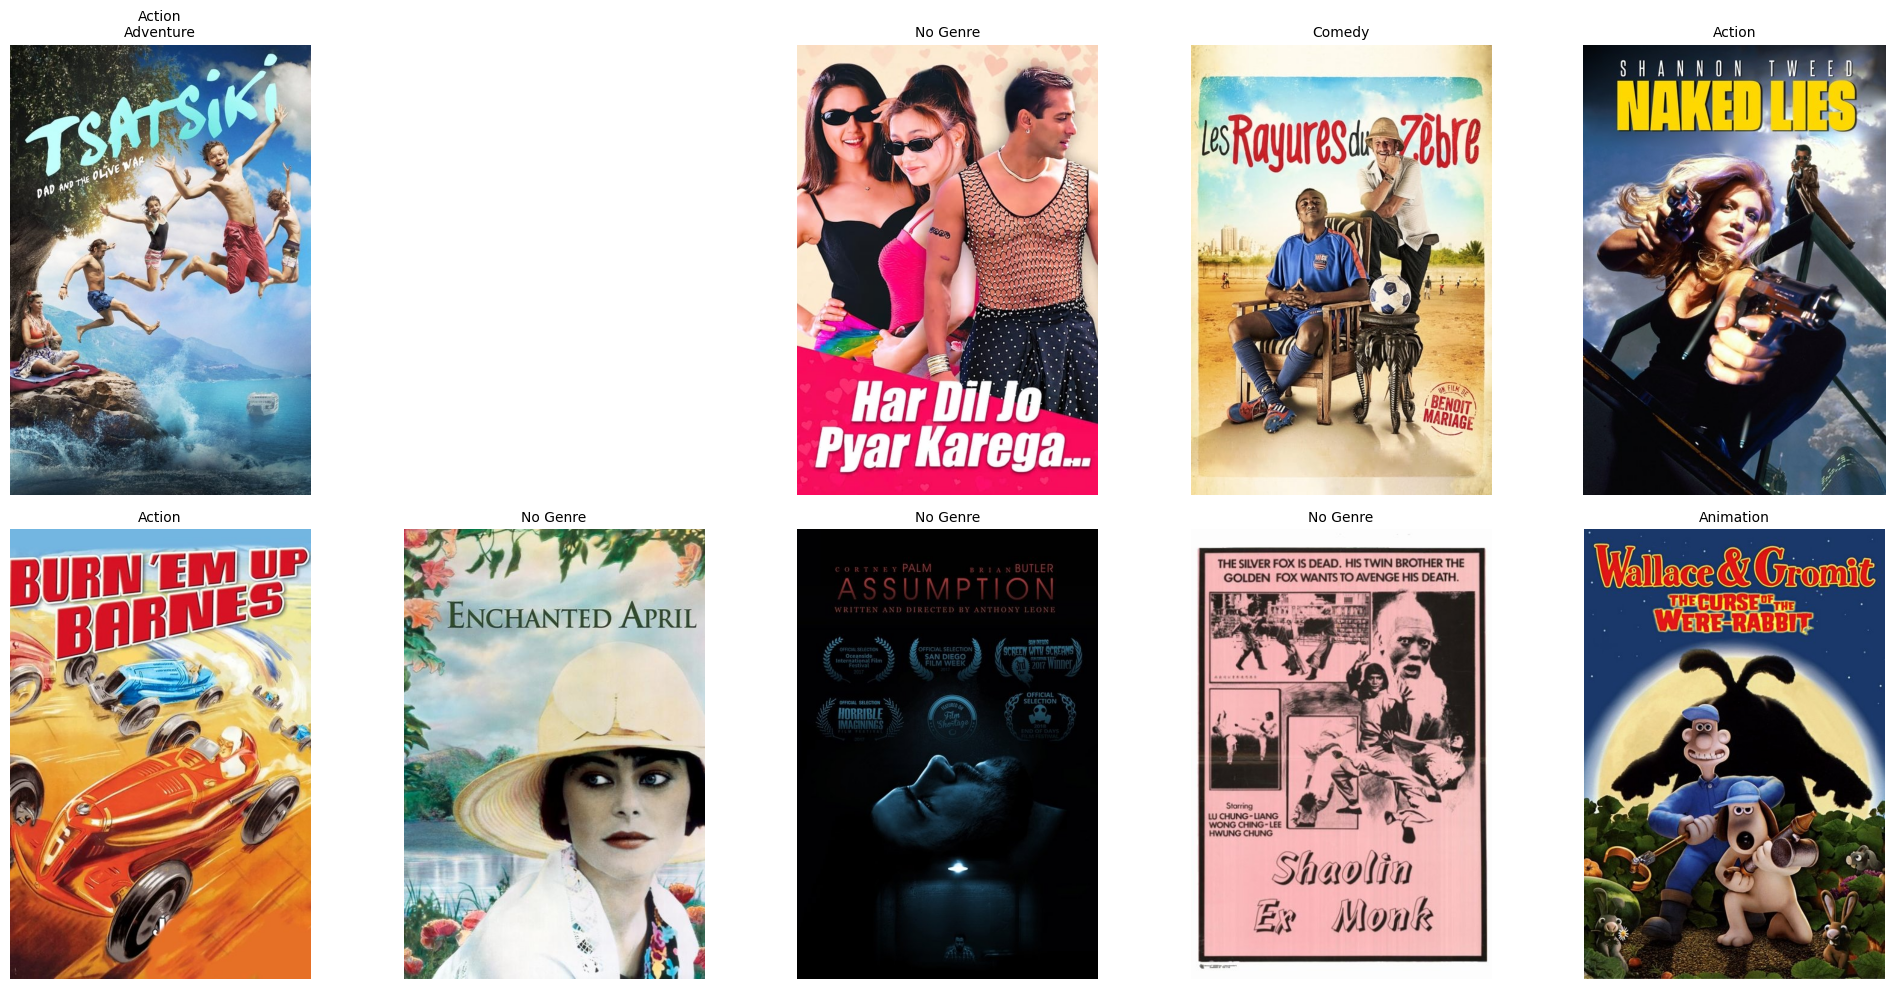

In [63]:
# Predict
predict_and_show_posters(resnet, mini_df, "mini_posters", transform, genre_columns, num_images=10, threshold=0.5)
